## Linear Discriminant Analysis - Normal vs. Isolate

## Imports

In [1]:
import avn.dataloading as dataloading
import avn.acoustics as acoustics
import avn.plotting as plotting
import avn.segmentation as segmentation
import avn.syntax as syntax

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import librosa
import os

from numpy.fft import fft, fftfreq
from scipy.signal.windows import hann
import scipy.signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Load Dataset

In [2]:
all_feats_normal = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\all_birds_all_feats_wseg_umap_updated.csv').drop(columns = 'Unnamed: 0')

In [3]:
all_feats_normal = all_feats_normal[all_feats_normal.Bird_ID != 'S389']

Let's drop the Duke deaf and control birds

In [4]:
all_feats_normal = all_feats_normal[~all_feats_normal.Condition.isin(['pre-deafening', 'post-deafening'])]
all_feats_normal.Condition.unique()

array(['Isolate', 'FP1_KD_post_tut', 'FP1_KD_pre_tut', 'GFP', 'Tutor',
       'Pupil', 'Rockefeller-Pupil'], dtype=object)

In [5]:
columns_to_drop = ['num_syllables', 'Condition', 'Bird_ID', 'entropy_rate']

In [6]:
all_feats_normal.groupby('Condition').count()

,Goodness_mean_median,Goodness_mean_min,Goodness_mean_max,Mean_frequency_mean_median,Mean_frequency_mean_min,Mean_frequency_mean_max,Entropy_mean_median,Entropy_mean_min,Entropy_mean_max,Amplitude_mean_median,...,Bird_ID,rhythm_entropy,CV_peak_rhythm_spectrum_frequency,syllable_duration_entropy,gap_duration_entropy,entropy_rate,entropy_rate_norm,num_syllables,mean_repetition_length,CV_repetition_length
Condition,,,,,,,,,,,,,,,,,,,,,
FP1_KD_post_tut,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
FP1_KD_pre_tut,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
GFP,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Isolate,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
Pupil,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
Rockefeller-Pupil,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
Tutor,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12


In [7]:
all_feats_normal = all_feats_normal.rename(columns = {'entropy_rate_norm' : 'syntax_entropy_rate'})

### Drop Amplitude Features

Amplitude features depend strongly on the specific recording conditions of a bird, and seem to vary strongly across colonies, so we will not consider these features in subsequent analyses. 

In [8]:
amplitude_features = all_feats_normal.columns[['Amplitude' in x for x in all_feats_normal.columns.tolist()]]

all_feats = all_feats_normal.drop(columns= amplitude_features)

## Normalize Feature Set

In [9]:
features_only = all_feats.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

scaler = StandardScaler()
scaler.fit(feature_mat)

StandardScaler()

In [10]:
all_feats.Condition.unique()

array(['Isolate', 'FP1_KD_post_tut', 'FP1_KD_pre_tut', 'GFP', 'Tutor',
       'Pupil', 'Rockefeller-Pupil'], dtype=object)

In [11]:
normal_and_iso = all_feats[~all_feats.Condition.isin([ 'FP1_KD_pre_tut'])]

In [12]:
features_only = normal_and_iso.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

feature_mat_norm = scaler.transform(feature_mat)

In [13]:
class_dict = {'pre-deafening' : 0, 
              'post-deafening' : 1, 
              'FP1_KD_post_tut' : 0, 
              'GFP' : 0, 
              'Pupil' :  0, 
              'Tutor' : 0, 
              'Rockefeller-Pupil': 0,
              'Isolate' : 2, 
              'FP1_KD_pre_tut' : 3}

y = [class_dict[x] for x in normal_and_iso.Condition]

## L1-Based Feature Selection

In [14]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [15]:
print(feature_mat_norm.shape)
lsvc = LinearSVC(C=0.1, penalty='l1', dual = False).fit(feature_mat_norm, y)
model = SelectFromModel(lsvc, prefit=True)
x_new = model.transform(feature_mat_norm)
x_new.shape

(94, 43)


(94, 10)

Alright, so this cuts down our feature set from 43 to only 10 features. What are those features? 

In [16]:
feature_idx = [lsvc.coef_ != 0]
features = features_only.columns[np.squeeze(feature_idx)]

In [17]:
features

Index(['Goodness_mean_median', 'Entropy_mean_median', 'Entropy_mean_min',
       'Entropy_mean_max', 'Frequency_modulation_mean_min', 'Pitch_mean_max',
       'duration_CV_min', 'rhythm_entropy', 'syllable_duration_entropy',
       'syntax_entropy_rate'],
      dtype='object')

In [18]:
feature_weights = pd.DataFrame({'feature' : features_only.columns.values, 
                                'weight' : np.squeeze(lsvc.coef_)})
feature_weights['abs_weight'] = np.abs(feature_weights.weight)
feature_weights.sort_values('abs_weight', ascending=False).head(10)

,feature,weight,abs_weight
40,syntax_entropy_rate,0.218971,0.218971
34,duration_CV_min,0.200880,0.200880
36,rhythm_entropy,0.181518,0.181518
7,Entropy_mean_min,-0.157605,0.157605
14,Pitch_mean_max,0.072506,0.072506
8,Entropy_mean_max,-0.066092,0.066092
0,Goodness_mean_median,-0.060925,0.060925
6,Entropy_mean_median,-0.044498,0.044498
10,Frequency_modulation_mean_min,-0.033572,0.033572
38,syllable_duration_entropy,0.014951,0.014951


## Classification Accuracy with Reduced Feature Set

In [19]:
model = LinearDiscriminantAnalysis()
model.fit(x_new, y)
X_transformed = model.transform(x_new)
X_transformed.shape

(94, 1)

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import sem

In [21]:
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=42)
scores = cross_val_score(model, X = x_new, y = y, scoring = 'accuracy', cv = cv, )

In [22]:
np.mean(scores)

0.9507407407407408

In [23]:
sem(scores)

0.011158053244902223

## Plotting Feature Weights

In [24]:
model = LinearDiscriminantAnalysis()
model.fit(x_new, y)
X_transformed = model.transform(x_new)
X_transformed.shape

(94, 1)

In [31]:
model.coef_.flatten()

array([-1.27864547, -0.11022664, -1.51921372, -1.32942176, -0.90526333,
        1.0979342 ,  2.08671464,  1.84263641,  0.07285076,  2.36351751])

In [32]:
weights = pd.DataFrame(model.coef_.flatten(), index = features)
weights = weights.sort_values(by = 0, ascending= False)

In [26]:
plt.rcParams.update({'font.size': 11})

Text(0.5, 1.0, 'Typical vs. Isolate Feature Weights')

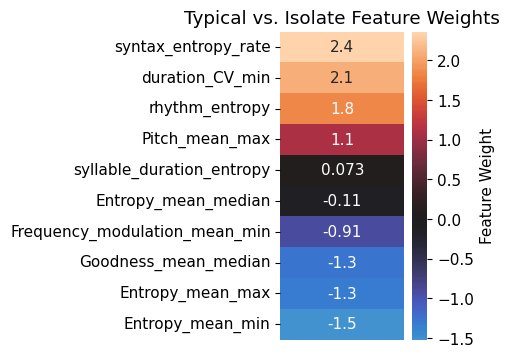

In [37]:
plt.figure(figsize=(2, 4))
sns.heatmap(weights, annot =True, center = 0, 
            cbar_kws={'label' : 'Feature Weight'})
plt.xticks([])
plt.title('Typical vs. Isolate Feature Weights')

In [44]:
pd.DataFrame(model.means_, columns = features, index = ['Typical', 'Isolate']).T

,Typical,Isolate
Goodness_mean_median,0.077675,-0.372372
Entropy_mean_median,0.241081,-0.998571
Entropy_mean_min,0.206881,-0.992245
Entropy_mean_max,0.149605,-0.673366
Frequency_modulation_mean_min,0.111304,-0.511733
Pitch_mean_max,-0.224121,0.885047
duration_CV_min,-0.361524,1.307518
rhythm_entropy,-0.309058,1.107766
syllable_duration_entropy,-0.285346,1.156145
syntax_entropy_rate,-0.372482,1.155776


These values don't match up with earlier figures because everything has been normalized and rescaled 